# Mth 9900
Independent study on Natural language processing, and providing applications in finance.

Sources:
  - Eisenstein, J. (2019). Introduction to natural language processing. Cambridge, MA: The MIT Press.
  
  - https://nlp.stanford.edu/pubs/stock-event.html
  
 

# Meeting 1
## Linear text classification

- 2.1 Bag of words
- 2.2 Naive Bayes
- 2.3 Perceptron
- 2.5 Logistic Regression
- Applications

## Bag of Words

Definitions:
  
  - Corpus: A Collection of documents
  
  - Document: A single entity 

To begin the process of assigning a document to a specific class, first we must be able to create a numerical representation of these documents.  One way of doing this is assigning a vector to each document.  In a "bag of words" scheme, each document is represented by a column vector with $V$ elements, where $V$ is the size of the possible vocabulary (usually defined as a the set of all valid words in the corpus).

Using a simple approach, let $X$ be the "bag of words" vector for $D$, where $D$ is the a document in the corpus.  Then $X_i$ can be the count of the i'th word in the vocabulary $V$, within $D$.   For example take the following "Document"

"the cat ran to the barn searching for the chickens" 

The vocabulary becomes ['the', 'cat', 'ran', 'to', 'barn', 'searching', 'for', 'chickens']

and $X$ = [2,1,1,1,1,1,1,1]

In practice, other schemes for assigning values in $X$ can be used.  These schemes can be, boolean (the word is in the document or not), term frequency (imposes that the sum of the vector is 1), term frequency-inverse document frequency, ect.

Additionally, preprocessing is sometimes desirable to normalize the documents, and possibly reduce the dimensions of $V$.   Notable examples are:
 - Lemmatization (converts words to there base or dictionary version)
 - Stemming (converts all words to there stems)
 - Removal of stop words
 

Once the bag of words is created, the task becomes making the accurate classification.   Let us assume that each documents $D$ in the corpus belongs to a specific class.  We seek a "score" of $D$ belonging to each class such that $\psi(x,y) = \Theta*f(x,y) = \sum_j\Theta_j f_j(x,y)$

- $\psi$ is a score of the compatability of the "bag of words" $x$, and the label $y$.
- $\Theta$ is a vector of weights imposed upon the bag of words.
- $f$ is called a feature function, which may be as simple as the count of words $x$ in document $y$

The goal of many classifiers is how to optimize $\Theta$, or assign these weights.

The assigned label become $\hat y =  argmax(\psi(x,y))$  assigning x to the label that maximizes  $\psi$

In multi-class operations ($k$ classes), the output  of $f(x,y)$ is a sparse vector of size $K*V$, and $\Theta$ is the same size.  Essentially it is as if there is a different $\Theta$ assigned to the vocabulary for each class.

### Bag of words Example

In [2]:
# read a text file 

with open('8K-gz/A') as infile:
    document = infile.read()
    # note this is a concatenation of all 8-K filings


'<DOCUMENT>\nFILE:A/A-8K-20020517172705.txt.gz\nTIME:20020517172705\nEVENTS:\tOther events\tFinancial statements and exhibits\nTEXT:\nITEM: Other events\nITEM: Financial statements and exhibits\nTable of Contents\nTable of Contents\nItem 5. Other Events.\nOn May 16, 2002, Agilent Technologies, Inc. (the "Company") announced its results for the three and six months ended April 30, 2002. A copy of the financial statements of the Company for the three and six months ended April 30, 2002 is attached as Exhibit 99.1.\nItem 7. Financial Statements and Exhibits\nTable of Contents\n     Pursuant to the requirements of the Securities Exchange Act of 1934, the registrant has duly caused this report to be signed on its behalf by the undersigned hereunto duly authorized.\nDate: May 17, 2002\nTable of Contents\n\nEXHIBIT 99.1 AGILENT TECHNOLOGIES, INC. CONDENSED CONSOLIDATED STATEMENT OF EARNINGS (In millions, except per share amounts) (UNAUDITED) Note: Amounts in the condensed consolidated financi

In [4]:
def naive_tokenize(document):
    """
    Naive because will just be splitting on spaces, no preprocessing.  Demonstration 
    purposes only
    """
    return document.split()
tokens = naive_tokenize(document)
# show a snapshot
tokens[1:5]


['FILE:A/A-8K-20020517172705.txt.gz',
 'TIME:20020517172705',
 'EVENTS:',
 'Other']

In [5]:
#define the vocabulary

V = set(tokens)

# if more then one document, V is set of all words in all documents
print(len(tokens), len(V))

1103139 25734


In [12]:
# create a term count BoW
from collections import OrderedDict

#initialize an empty map
blank_word_map = OrderedDict()
for i in V:
    blank_word_map[i] = 0

# with multiple documents we need to ensure order is perserved, 
# because sets are unordered we do not want to reconstruct the 
# blank word map for each document 

word_map = blank_word_map
for i in tokens:
    word_map[i] += 1
bag_of_words = list(word_map.values())
len(bag_of_words)

25734

In [13]:
bag_of_words[1:5]

[3, 229, 1, 10]

## Naive Bayes

One of the ways the $\theta$ from the above general problem can be learned is by using a probabilistic model called naive bayes. 

In [19]:
class MultinomialNB(object):
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        count_sample = X.shape[0]
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in separated]
        count = np.array([np.array(i).sum(axis=0) for i in separated]) + self.alpha
        self.feature_log_prob_ = np.log(count / count.sum(axis=1)[np.newaxis].T)
        return self

    def predict_log_proba(self, X):
        return [(self.feature_log_prob_ * x).sum(axis=1) + self.class_log_prior_
                for x in X]

    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)
    

In [10]:
X = np.array([
    [2,1,0,0,0,0],
    [2,0,1,0,0,0],
    [1,0,0,1,0,0],
    [1,0,0,0,1,1]
])
y = np.array([0,0,0,1])
nb = MultinomialNB().fit(X, y)

X_test = np.array([[3,0,0,0,1,1],[0,1,1,0,1,1]])
print(nb.predict(X_test))



[0 1]


## Perceptron

In [16]:

class Perceptron(object):
    """Implements a perceptron network"""
    def __init__(self, input_size, lr=1, epochs=100):
        self.W = np.zeros(input_size+1)
        # add one for bias
        self.epochs = epochs
        self.lr = lr
    
    def activation_fn(self, x):
        #return (x >= 0).astype(np.float32)
        return 1 if x >= 0 else 0
 
    def predict(self, x):
        z = self.W.T.dot(x)
        a = self.activation_fn(z)
        return a
 
    def fit(self, X, d):
        for _ in range(self.epochs):
            for i in range(d.shape[0]):
                x = np.insert(X[i], 0, 1)
                y = self.predict(x)
                e = d[i] - y
                self.W = self.W + self.lr * e * x
                return self

In [23]:
X = np.array([
    [2,1,0,0,0,0],
    [2,0,1,0,0,0],
    [1,0,0,1,0,0],
    [1,0,0,0,1,1]
])
y = np.array([0,0,0,1])
p = Perceptron(6).fit(X, y)

X_test = np.array([[3,0,0,0,1,1,1],[0,1,1,0,1,1,1]])
print(p.predict(X_test[0]))
print(p.predict(X_test[1]))


0
0


array([-1., -2., -1.,  0.,  0.,  0.,  0.])

## Logistic Regression

In [24]:
class LogisticRegression:
    def __init__(self, lr=0.01, n_iter=100):
        self.lr = lr
        self.n_iter = n_iter

    def predict(self, X):
        X = self.normalize(X)
        linear = self._linear(X)
        preds = self._non_linear(linear)
        return (preds >= 0.5).astype('int')

    def _non_linear(self, X):
        return 1 / (1 + np.exp(-X))

    def _linear(self, X):
        return np.dot(X, self.weights) + self.bias

    def initialize_weights(self, X):
        # We have same number of weights as number of features
        self.weights = np.random.rand(X.shape[1], 1)
        # we will also add a bias to the terms that
        # can be interpretted as y intercept of our model!
        self.bias = np.zeros((1,))

    def fit(self, X_train, Y_train):
        self.initialize_weights(X_train)

        # get mean and stddev for normalization
        self.x_mean = X_train.mean(axis=0).T
        self.x_stddev = X_train.std(axis=0).T

        # normalize data
        X_train = self.normalize(X_train)

        # Run gradient descent for n iterations
        for i in range(self.n_iter):
            # make normalized predictions
            probs = self._non_linear(self._linear(X_train))
            diff = probs - Y_train

            # d/dw and d/db of mse
            delta_w = np.mean(diff * X_train, axis=0, keepdims=True).T
            delta_b = np.mean(diff)

            # update weights
            self.weights = self.weights - self.lr * delta_w
            self.bias = self.bias - self.lr * delta_b
        return self

    def normalize(self, X):
        X = (X - self.x_mean) / self.x_stddev
        return X

    def accuracy(self, X, y):
        preds = self.predict(X)
        return np.mean(preds == y)

    def loss(self, X, y):
        probs = self._non_linear(self._linear(X))

        # entropy when true class is positive
        pos_log = y * np.log(probs + 1e-15)
        # entropy when true class is negative
        neg_log = (1 - y) * np.log((1 - probs) + 1e-15)

        l = -np.mean(pos_log + neg_log)
        return l

## Applications

In [79]:
import glob
import pandas as pd
import re
import tqdm
import datetime as dt



100%|██████████| 1500/1500 [02:13<00:00, 10.34it/s]


In [ ]:
files = glob.glob('8K-gz/*')

df = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'return', 'fwd1d_returns', 'k8', 'ticker'])
df.to_csv('total_data.csv', index = False)


for file in tqdm.tqdm(files):
    """
       Get price history
    """
    ticker = file.split('/')[1]
    return_file = 'price_history/' + file.split('/')[1] + '.csv'
    returns = pd.read_csv(return_file)
    returns['return'] = returns['Adj Close'].pct_change(-1)
    returns['fwd1d_returns'] = returns['return'].shift(2)
    returns['Date'] = pd.to_datetime(returns['Date'])
    
    
    with open(file) as infile:
        document = infile.read()
    mo = re.compile('(<DOCUMENT>)(.*?)<\DOCUMENT>', re.DOTALL)
    k8s = mo.findall(document)
    if len(k8s) > 0:
        processed_k8s= []
        for k8 in k8s:
            date_mo = re.compile('(TIME:)(\d{8})')
            date = date_mo.search(k8[1]).group(2)
            processed_k8s.append({'Date': date, 'k8': k8[1], 'ticker': ticker})
        processed_k8s = pd.DataFrame(processed_k8s)
        processed_k8s.Date = pd.to_datetime(processed_k8s.Date)
    
   
        total_data = returns.merge(processed_k8s, how = 'outer', on = 'Date').dropna()
        total_data.to_csv('total_data.csv',header = False, index = False, mode = 'a')


In [84]:
data = pd.read_csv('total_data.csv')
data.Date = pd.to_datetime(data.Date)
print(max(data.Date), min(data.Date))


print(data[data.Date > dt.datetime(year = 2009, month = 12, day = 31)].shape)

test = data[data.Date >= dt.datetime(year = 2009, month = 12, day = 31)]
train = data[data.Date < dt.datetime(year = 2009, month = 12, day = 31)]
test.to_csv('test.csv', index = False)
train.to_csv('train.csv', index = False)

2013-01-30 00:00:00 1994-12-06 00:00:00
(29650, 11)


# Meeting 2
## Non Linear Text Classification
- Feedforward Neural Networks
- Designing Neural Networks
- Learning Neural Networks
- Convolutional Neural Networks

## Feed Forward Neural Networks

The story told in 3.1 of the books begins with a simple classification problem.  Given movie reviews, we want to predict if the movie is good, bad, or okay.    But the acctual features we wish to use to predict the movie reviews will be things such as cinematography, acting, story etc., let call this z, and lets call good, bad, ok y.   We will use x (the text) to predict z, then use z to predict x.

Specifically we will use logistic regression for both predictions (assuming we have observations of z)

The resulting multilayer classifer can be summarized as 

$p(z|x;\Theta^{x \rightarrow z}) = \sigma (\Theta^{x \rightarrow z}x)$

$p(y|z; \Theta^{y \rightarrow y}, b) = SoftMax(\Theta ^{z \rightarrow y}z+b)$

Note that this construction requires an observation of z. 

We can alter the construct so z is treated as a hidden, unobserved layer.

This construction is 
$z = \sigma(\Theta^{x \rightarrow z}x)$

This defines a feed forward neural network where $\sigma$ is an activation function

## Designing Neural Networks
These hidden layers, z in the previous chapter can be viewed as laten features.   The activation function defines how much the features is activated by the input.  

Below are a list of popular activation functions

- sigmoid
  - The range is (0,1) and this ensure the function does not blow up on huge inputs. 
  - the derivative is $\sigma(a)(1-\sigma(a))$
  - This value can become very small, creating a vanishing gradient
- tanh
  - The range is bounded (-1,1).  Note it can have negative values
  - the derivative $1-tanh(a)^2$, is steeper than sigmoid, but still vanishes
- ReLU
  - a if a >0 else 0
  - derivative is a step function, 1 if positive else 0
  - This can create dead neurons and can be fixed by redefining a leaky Relu
  - a if a >0 else .001a
  
A deep network will stack up several hidden layers, which the output of each layer acting as the input too the next layer.  As the number of nodes in the network increase, it can learn increasingly complex functions.  One has the choice to emphasize width (dimension of the hidden layer) or depth ( number of layers) with an unclear trade off.

Some of the problems in neural networks can be offset using more complex network strategies
- Residual Network:
  - input nodes propegate information directly to a subsequent layer to offset the vanishing gradient problem
- Highway network

For multilayer classifications, generally the softmax function is used to learn the probability of a feature set corresponding to each class.   This corresponds to estimating the loss function of the negative conditional log liklihood 

$\tilde{y} = p(y=j|x_i; \Theta)$

$ -L = - \sum e_{(i)} * log( \tilde y)$ where $e_{(i)}$ is a one hot encoded vector of y

In learning language, the weights on these hidden layers can be viewed as a "word embedding" more to be covered in chapter 14.

# Meeting 3

This meeting is meant to cover Chapter 4 of the text, however, because chapter 4 is not very technical in nature, I will also deviate to cover, and learn tensorflow, and provide a simple overview of chapter 4.
- Sentiment and opinion analysis
- Word Sense Disambiguation
- Design Decisions
- Evaluation Classifiers
- Building Datasets

## Sentiment and Opinion analysis

One simple and common task for Natural Language processing is sentiments or opinion analysis.   Take for example the canonical "IMDB review dataset", and predict sentiments (good, negative, neutral) of the others.   Historically, lexicon based sentiment analysis avoided any machine learning and instead constructed a lexicon of "good" or "negative" words.   These have recently fallen out of favor and suffer from numerous pitfalls:
 - inherent bias in the construction of the lexicon
 - Missing negation, especially in short documents

Further work has now been done in "Targeted Sentiment Analysis" which instead of predicting the sentiment of the document overall, predicts the sentiment of the authoer to a specific entity.  Take for example "the vodka was good, but the meat was rotten"   The sentiment towards vodka was positive, well negative for meat.

## Word Sense Disabmiguation

Another application of natural language processing is word sense disabmbiation.  In fact there exist a corpus of wordsenses provided by NLTK called word net.   These disambiguations are important in such aspects as lemmatization (in face the word sense is a propertiy of the lemma.
 - Example arm, arms as nouns refering to anatomy
 - arm, arms, armed, arming as verbs refering to providing a weapon 
 The base unit of wordnet is a sysnet, or lemmas that are synonymous.  A lemma can belong to multiple sysnets.
 Word net also maps other relations 
 - antonymy: x opposite y
 - hyponymy: x is specialization of y
 - hypernymy: x is a generallization of y
 - meronymy: x is part of y
 
## Design Decisions

Some careful design decision in the NLP task include tokenization, normalization, and vectorization.  Tokenzation deals with you systems definition of a word.   In fact how a token is defined can have large impacts on the results.  Especially if your target corpus is prose vs. social media.    Take for example prose, it is fairly straight forward to split on white space, remove contractions, remove non alphanumeric tokens, and convert to lower case.  This would not work for say a tweet.   However, also take for example the task of named entity recognition, in this example you would not want to make the text lowercase.

After tokenization comes normalization (this actually includes the case desicion).  But also you can limit your vocabulary by using either stemming, or lemmatizations.  This is also the point where you make vocabulary desicions that can be either impacted by computational neccesity (not enough space) or by avoiding overfitting.   For example, in the case below on 62,000 training examples, I had 29,000 words.  I limited this too 4000 for space reasons, however even in the Neural Network model I had nearly 20,000 parameters.

Then we consider count, binary, tfidf, or term frequency in terms of the vectorization scheme.   For small documents binary might be sufficient, but in longer documents may not work.

## Evaluation Classifiers
In binary classification lets consider 4 cases,  false positive, false negative, true positive, and true negative

-Accuracy
 - (TP + TN)/(TP+TN + FP + FN)
- Precision
 - TP / (TP + FP)
 - Can be viewd as the conditional liklihood it is predicted true given it is  true
- Recall
 - TP \ (TP + FN)
 - Can be viewed as the liklihood it is true given it was predicted true.
- F Measure
  = 2rp/(r+p)
  
Not recall and precision are complementaray and do have a trade off.  You want to focus on recall when false positives are cheap relative to false negatives.  Precision is prefered when false positives are more expensive.  This entirley depends upon the domain.



## Building Classification Models with TensorFlow and Building Regression Models Using TensorFlow from PluralSight

Notes not taken here, but relevent demo will be implemented.


### Establishing a baseline to compare prediction too.

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model, load_model

def get_label(x):
    if x < 0.01:
        return -1
    elif x > 0.01:
        return 1
    else:
        return 0


In [2]:
train = pd.read_csv('train.csv')
train.head()

Date   Open   High    Low  Close      Volume  Adj Close    return  \
0  2009-12-16  55.91  57.00  53.56  54.18   6258900.0      52.50 -0.021618   
1  2009-11-19  55.33  55.55  53.60  54.86   3076200.0      52.99 -0.020336   
2  2009-06-03  35.19  36.75  34.47  36.11  10812300.0      34.72  0.019378   
3  2009-03-04  17.17  18.52  16.85  17.55  13346900.0      16.79  0.107520   
4  2008-12-15  22.54  23.73  21.71  22.06   3312400.0      20.87 -0.002867   

   fwd1d_returns                                                 k8 ticker  
0      -0.012584  \nFILE:JOY/JOY-8K-20091216105738.txt.gz\nTIME:...    JOY  
1      -0.007664  \nFILE:JOY/JOY-8K-20091119182326.txt.gz\nTIME:...    JOY  
2       0.059111  \nFILE:JOY/JOY-8K-20090603105633.txt.gz\nTIME:...    JOY  
3       0.053225  \nFILE:JOY/JOY-8K-20090304105640.txt.gz\nTIME:...    JOY  
4       0.125466  \nFILE:JOY/JOY-8K-20081215173304.txt.gz\nTIME:...    JOY

In [3]:
train.shape

(62703, 11)

In [4]:
train = train[['fwd1d_returns', 'k8']]
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 4000)
X = vectorizer.fit_transform(train['k8']).todense()


In [5]:
print(len(vectorizer.get_feature_names()))

4000


In [5]:


#labels = train.apply(lambda x: get_label(float(x['fwd1d_returns'])), axis = 1)
#labels.head()

In [7]:
clf = GaussianNB()
clf.fit(X, labels)
x_pred = clf.predict(X)
print(precision_score(labels, x_pred, average = 'macro'))

0.555188307315433


In [8]:
with open('vectorizer', 'wb') as outfile:
    pickle.dump(vectorizer, outfile)
with open('clfgnb', 'wb') as outfile:
    pickle.dump(clf, outfile)

test = pd.read_csv('test.csv')
test = test[test.ticker != 'SUN']

In [9]:
label = test.apply(lambda x: get_label(float(x['fwd1d_returns'])), axis = 1)
x_test = vectorizer.transform(test.k8).todense()
y_test = clf.predict(x_test)
print(precision_score(label, y_test, average = 'macro'))

0.5078874319252387


In [25]:
test['trade_signal'] = y_test
wealth = 10000

In [28]:
dates = []
pos = []
for i, group in test.groupby('Date'):
    longs = group[group.trade_signal == 1]
    if longs.trade_signal.sum() > 0:
            weight = 1/longs.trade_signal.sum()
            inv_per_pos = wealth * weight
            return_vec = longs.fwd1d_returns * inv_per_pos
            wealth += sum(return_vec)
    shorts = group[group.trade_signal == -1]
    if shorts.trade_signal.sum() > 0:
            weight = 1/shorts.trade_signal.sum()
            inv_per_pos = wealth * weight
            return_vec = shorts.fwd1d_returns * inv_per_pos
            wealth += sum(return_vec)
        
    dates.append(i)
    pos.append(wealth)

In [29]:
pos

[9855.17625854588,
 9849.910890353813,
 9872.234923178401,
 10005.408368956258,
 9972.553146300444,
 9859.776046316916,
 9988.351936219316,
 10052.938947649358,
 9968.5705065199,
 10062.222127490375,
 9933.738289368059,
 9775.87709331169,
 9561.08426997724,
 9564.750668427976,
 9448.340434963193,
 9467.73023285606,
 9351.058354658144,
 9265.690489576127,
 9388.906117270732,
 9448.119561718444,
 9413.22319690501,
 9118.477406488973,
 9200.648561886093,
 9137.509157710421,
 9253.31125617517,
 9311.563784898653,
 9485.601634601446,
 9497.497848647597,
 9684.481982534544,
 9732.022591257493,
 9782.053590596033,
 9866.43891837176,
 9826.62706048468,
 9668.970460042348,
 9749.196775064047,
 9764.285575187114,
 9733.31788825327,
 9890.691751399916,
 9955.852904422556,
 10110.992232406901,
 10124.130965336326,
 10378.699250083506,
 10355.191397951165,
 10354.986171174469,
 10427.334321471713,
 10480.451205561636,
 10484.378646343788,
 10482.535859277305,
 10530.928133912272,
 10604.38386981780

In [30]:
data = [[dates[i], pos[i]] for i in range(len(dates))]
returns_df =pd.DataFrame(data, columns = ['date', 'pos'])


In [31]:
returns_df.date = pd.to_datetime(returns_df.date)

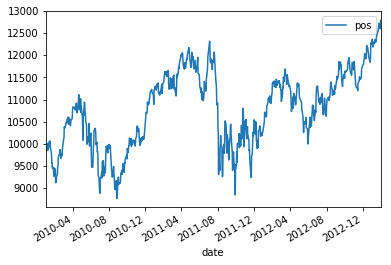

In [32]:
returns_df.set_index('date', inplace = True)
returns_df.plot()

In [33]:
test.head()


Date   Open   High    Low  Close     Volume  Adj Close    return  \
0  2013-01-11  68.64  69.00  67.96  68.13  1560600.0      68.13 -0.008297   
1  2012-12-14  60.28  62.79  60.21  61.64  3549900.0      61.64  0.020530   
2  2012-10-26  60.16  63.30  59.30  61.55  6714500.0      61.36  0.030222   
3  2012-09-21  61.45  61.72  59.40  59.41  2482000.0      59.23 -0.021315   
4  2012-08-08  54.77  57.36  54.31  56.17  3083200.0      55.82  0.020102   

   fwd1d_returns                                                 k8 ticker  \
0       0.002639  \nFILE:JOY/JOY-8K-20130111100843.txt.gz\nTIME:...    JOY   
1       0.022124  \nFILE:JOY/JOY-8K-20121214163949.txt.gz\nTIME:...    JOY   
2       0.057340  \nFILE:JOY/JOY-8K-20121026161548.txt.gz\nTIME:...    JOY   
3      -0.054676  \nFILE:JOY/JOY-8K-20120921090015.txt.gz\nTIME:...    JOY   
4       0.008868  \nFILE:JOY/JOY-8K-20120808121853.txt.gz\nTIME:...    JOY   

   trade_signal  
0            -1  
1             1  
2            -1  
3             1  
4             1

In [34]:
test[test.trade_signal != 0].to_csv('test_trade_signal.csv')

count    766.000000
mean       0.000995
std        0.023459
min       -0.102115
25%       -0.011416
50%        0.000739
75%        0.013799
max        0.086652
Name: pos, dtype: float64

In [68]:
check[check.trade_signal==1]

fwd1d_returns  trade_signal  \
764        -0.004154             1   
2336       -0.003557             1   
2565       -0.024643             1   
3456       -0.022336             1   
3841       -0.014487             1   
4661       -0.037717             1   
5463        0.002832             1   
5535       -0.017639             1   
20840      47.757143             1   
26358      -0.028871             1   
28398      -0.039185             1   

                                                      k8  
764    \nFILE:WRC/WRC-8K-20110114163614.txt.gz\nTIME:...  
2336   \nFILE:INTC/INTC-8K-20110114101529.txt.gz\nTIM...  
2565   \nFILE:CME/CME-8K-20110114161418.txt.gz\nTIME:...  
3456   \nFILE:HWKN/HWKN-8K-20110114161321.txt.gz\nTIM...  
3841   \nFILE:COF/COF-8K-20110114174647.txt.gz\nTIME:...  
4661   \nFILE:SUSQ/SUSQ-8K-20110114162633.txt.gz\nTIM...  
5463   \nFILE:ABT/ABT-8K-20110114090030.txt.gz\nTIME:...  
5535   \nFILE:WBS/WBS-8K-20110114081256.txt.gz\nTIME:...  
20840  \nFILE:SUN/SUN-8K-20110114164542.txt.gz\nTIME:...  
26358  \nFILE:CLD/CLD-8K-20110114091541.txt.gz\nTIME:...  
28398  \nFILE:NCS/NCS-8K-20110114114552.txt.gz\nTIME:...

In [72]:
test[(test.Date == '2011-01-14') & (test.ticker == 'SUN')]

Date  Open  High  Low  Close  Volume  Adj Close  return  \
20840  2011-01-14   0.0   0.0  0.0    0.0   100.0        0.0    -1.0   

       fwd1d_returns                                                 k8  \
20840      47.757143  \nFILE:SUN/SUN-8K-20110114164542.txt.gz\nTIME:...   

      ticker  trade_signal  
20840    SUN             1

In [70]:
list(test)

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Adj Close',
 'return',
 'fwd1d_returns',
 'k8',
 'ticker',
 'trade_signal']

### Demo Using TensorFlow to to Same  Classification Task

In [8]:
with open('vectorizer', 'rb') as pkl:
    vectorizer = pickle.load(pkl)
data = pd.read_csv('train.csv', usecols = ['fwd1d_returns', 'k8'])

In [6]:
Y = data.apply(lambda x: get_label(x.fwd1d_returns), axis = 1)
X = vectorizer.transform(data.k8)

In [7]:

neg = Y.apply(lambda x: 1 if x == -1 else 0)
same = Y.apply(lambda x: 1 if x == 0 else 0)
up = Y.apply(lambda x: 1 if x == 1 else 0)
Y = pd.concat([neg, same, up], axis =1).values
X.shape, Y.shape


((62703, 4000), (62703, 3))

0   -1
1    1
2    1
3   -1
4   -1
dtype: int64

In [8]:
input_layer = Input(shape = (X.shape[1],))
dense_layer_1 = Dense(5, activation = 'relu')(input_layer)
dense_layer_2 = Dense(5, activation = 'relu')(dense_layer_1)
output = Dense(3, activation = 'softmax')(dense_layer_2)
model = Model(inputs = input_layer, outputs = output)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4000)]            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 20005     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 18        
Total params: 20,053
Trainable params: 20,053
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
history = model.fit(X.todense(), Y, batch_size = 8, epochs = 35, verbose = 1)

Train on 62703 samples
Epoch 1/35
62703/62703 [==============================] - 21s 342us/sample - loss: 0.6139 - accuracy: 0.7057
Epoch 2/35
62703/62703 [==============================] - 22s 347us/sample - loss: 0.5993 - accuracy: 0.7059
Epoch 3/35
62703/62703 [==============================] - 22s 355us/sample - loss: 0.5938 - accuracy: 0.7059
Epoch 4/35
62703/62703 [==============================] - 22s 347us/sample - loss: 0.5899 - accuracy: 0.7059
Epoch 5/35
62703/62703 [==============================] - 22s 346us/sample - loss: 0.5869 - accuracy: 0.7066
Epoch 6/35
62703/62703 [==============================] - 22s 346us/sample - loss: 0.5840 - accuracy: 0.7071
Epoch 7/35
62703/62703 [==============================] - 21s 342us/sample - loss: 0.5803 - accuracy: 0.7066
Epoch 8/35
62703/62703 [==============================] - 21s 342us/sample - loss: 0.5757 - accuracy: 0.7090
Epoch 9/35
62703/62703 [==============================] - 22s 353us/sample - loss: 0.5694 - accuracy: 0.7

In [16]:
model.save('tf_2layer.h5')

In [9]:
model = load_model('tf_2layer.h5')
data= pd.read_csv('test.csv', usecols = ['fwd1d_returns', 'k8', 'ticker', 'Date'])
Y= data.apply(lambda x: get_label(x.fwd1d_returns), axis = 1)
X = vectorizer.transform(data.k8)
neg = Y.apply(lambda x: 1 if x == -1 else 0)
same = Y.apply(lambda x: 1 if x == 0 else 0)
up = Y.apply(lambda x: 1 if x == 1 else 0)
Y = pd.concat([neg, same, up], axis =1).values
X.shape, Y.shape


((29657, 4000), (29657, 3))

In [20]:
score = model.evaluate(X.todense(), Y)

29657/29657 [==============================] - 2s 83us/sample - loss: 0.7898 - accuracy: 0.6790


In [12]:
predict = model.predict(X.todense())

predict = [ 1 if i[2] ==max(i) else -1 if i[0] == max(i) else 0 for i in predict]
data['trade_signal'] = predict

In [14]:
wealth = 10000
dates = []
pos = []
for i, group in data.groupby('Date'):
    longs = group[group.trade_signal == 1]
    if longs.trade_signal.sum() > 0:
            weight = 1/longs.trade_signal.sum()
            inv_per_pos = wealth * weight
            return_vec = longs.fwd1d_returns * inv_per_pos
            wealth += sum(return_vec)
    shorts = group[group.trade_signal == -1]
    if shorts.trade_signal.sum() > 0:
            weight = 1/shorts.trade_signal.sum()
            inv_per_pos = wealth * weight
            return_vec = shorts.fwd1d_returns * inv_per_pos
            wealth += sum(return_vec)
        
    dates.append(i)
    pos.append(wealth)

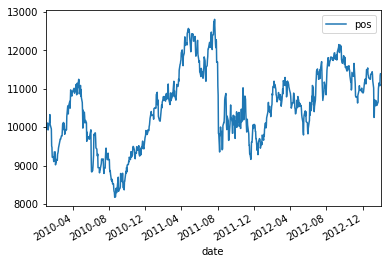

In [15]:
data = [[dates[i], pos[i]] for i in range(len(dates))]
returns_df =pd.DataFrame(data, columns = ['date', 'pos'])
returns_df.date = pd.to_datetime(returns_df.date)
returns_df.set_index('date', inplace = True)
returns_df.plot()

## Take Aways

My original tokenization scheme was to memory intesnsive.

I constructed a normal CNN vise the models shown in the tutorials 1) because the tutorials were in TN 1.xx, and two I am not sure the impact of there preproccing.   Even tensorflow tutorial has a weird feature where they pass in 1 hot encoded vectors of words. 

It may be useful to limit the vocabulary.   The MutinomialNB beat the CNN on precision, and I believe part of that had to do with the number of parameters in the CNN

A future week deals with word encodings, which can be a good target for LSTM and RNN.   These models did not seem to fit appropriatley for this classification task.

# Meeting 4 
## Learning without supervision

- Unsupervised Learning
- Applications of Expectation Maximization
- Semi-supervised learning
- Domain adaptation
- Other Approaches 



## Unsupervised Learning

Consider the task of word sense disambiguation.   We have instances of the word "bank" and want to classify it into its different word senses.

One way to and do this is to take the "context words" or, say the rest of the words in the sentence, create clusters.  In n-dimensions we may be able to see different clusters forming representing the different instances of the word bank.

One useful clustering algorithm is Kmeans clustering.   It seeks to place each example into 1 of k clusters, and is a fairly simple algorightm.

Assign each instance to a random cluster
Compute the cluster centers
assign each instance to which ever center it is closest to.
recompute cluster center
and repeat until converged.

Another example exist called soft k means.  Which isntead of assigning each point to a cluster, it assigns each point to a distrubition over the cluster.

The solution to soft k-means can be found using Expectation Maximizations, which can be broken down into two steps.

Consider the lower bound for the marginal-liklihoods of the observed data but now over latent or unobserved outputs.

$\sum_1^N E_{q^{i}}[log p(x^i, z;,\sigma, \mu)] + H(q^i)$

where $H(q^i) = -\sum_1^Kq^i(z) log q^i(z)$
We now note that this maximization problem is a function of two groups of parameters,  mainly the disribution from which the expectatios is computed and then the parameters of the distrubtion


To make it simple, the EM algorithm iterativly computes two values.  1) it computes the expectation of $q^i$ using the parameters $\sigma, \mu$.   Then it computes the parameters $\sigma, \mu$ which maximizethe above function and iteratively continues until convergence.  Note that it does not find a global solution, and there for initial guesses do determine which local solution it finds.


## Applications of Expectation Maximization

- word sense induction
    - treating each cluster as a latent variable
    - in this case often using SVD then truncatign the matrix of context counts
- semi-supervised learning
    - Suppose we have some labeled and unlabeled data.  We combine the loss functions of Naive bayes an EM over the respective groups. The E step still updates the distribution, but the M step now updates the parameters using expected counts from unlabelled data and observed counts from labeled data.
    - One mus be concerned about the size of the labelled and ulabelled data.

## Semi Supervised Learning

While Expectation Maximization is useful for semi supervised learning. We can explore some non - probablistic approaches

- Multi view learning   
    - Each feature can be grouped into differents views (ex. the word itsself, or its context)
    - Cotraining: Multi view learning algorithm in which multiple classifiers are used.  For example use classifier 1 predictions on a subset too train view 2's classifier.
    - Graph based algorithm constructs a weighted graph to propgate a small set of labelled instances into a larger set. 

## Domain Adaption

Consider using a model trained on say wikipedia, or new group datasets, then using this to make predictions on say annual company filings.    Depending on the context, this may not be fruitful, as the domains of the data that was used to train the classifier and the target data lie in different domains.


- Supervised Domain Adaptions
    - Useful when there is alot of data in a source domain and less in a target domain
    - Directly use the classifier
    - Interpolation: train a classifier for each domain and interpolate
    - Prediction: Train a classifier on the source domain, use it prediction as an additional feature in the target domain
    - Priors: Use the weights of the model trained on the source domain as a prior for the classifier on the target domain.
- Unsupervised Domain Adaptation
    - This is used when there is no labelled data in the target domain
    - Instead we learn a projection function to put both target, and source domains in a shared space.  And have the learner generalize across domains
    - Linear projection: Create a set of "pivot featuers" shared by the domains.  Use the base features to predict the presence of a pivot feature j for each example. Concatenate those weights. Perform SVD  
    - Using a neaural network to learn a Non linear projections.

## Coding Examples.

In [12]:
"""
Checking if the clusters correspond to the returns
"""

import pandas as pd
data = pd.read_csv('train.csv')

import pickle
with open('vectorizer', 'rb') as pkl:
    vectorizer = pickle.load(pkl)
data = pd.read_csv('train.csv', usecols = ['fwd1d_returns', 'k8'])

In [13]:
features = vectorizer.transform(data.k8)

In [18]:
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters = 3, verbose = True)
cluster.fit(features)


Initialization complete
Iteration  0, inertia 95997.536
Iteration  1, inertia 51197.895
Iteration  2, inertia 50491.339
Iteration  3, inertia 50445.987
Iteration  4, inertia 50436.365
Iteration  5, inertia 50434.422
Iteration  6, inertia 50434.139
Iteration  7, inertia 50434.105
Iteration  8, inertia 50434.099
Iteration  9, inertia 50434.098
Converged at iteration 9: center shift 0.000000e+00 within tolerance 2.174909e-08
Initialization complete
Iteration  0, inertia 101255.601
Iteration  1, inertia 51219.654
Iteration  2, inertia 50670.422
Iteration  3, inertia 50607.612
Iteration  4, inertia 50526.223
Iteration  5, inertia 50456.814
Iteration  6, inertia 50438.912
Iteration  7, inertia 50434.898
Iteration  8, inertia 50434.196
Iteration  9, inertia 50434.115
Iteration 10, inertia 50434.101
Iteration 11, inertia 50434.098
Converged at iteration 11: center shift 1.955167e-08 within tolerance 2.174909e-08
Initialization complete
Iteration  0, inertia 100767.582
Iteration  1, inertia 514

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=True)

In [19]:
data['cluster'] = cluster.predict(features)

In [20]:
data.head()

fwd1d_returns                                                 k8  cluster
0      -0.012584  \nFILE:JOY/JOY-8K-20091216105738.txt.gz\nTIME:...        2
1      -0.007664  \nFILE:JOY/JOY-8K-20091119182326.txt.gz\nTIME:...        1
2       0.059111  \nFILE:JOY/JOY-8K-20090603105633.txt.gz\nTIME:...        2
3       0.053225  \nFILE:JOY/JOY-8K-20090304105640.txt.gz\nTIME:...        2
4       0.125466  \nFILE:JOY/JOY-8K-20081215173304.txt.gz\nTIME:...        1

In [22]:

for i in range(3):
    group = data[['fwd1d_returns','cluster']][data.cluster == i]
    print ("group {}".format(i))
    print("Avg returns {}".format(group.fwd1d_returns.mean()) )
    print("std returns {}".format(group.fwd1d_returns.std()) )

group 0
Avg returns 0.0007907779927259563
std returns 0.03226013437391648
group 1
Avg returns 0.0005442396269733084
std returns 0.030232778755558756
group 2
Avg returns 0.0005782353036794485
std returns 0.030689716275854335


We can see, that at least in this construction, these groups are not in anyway predicting forward returns.

# Meeting 5

## Simple Word Embeddings

In [33]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('train.csv')

In [4]:
tokenizer = Tokenizer(num_words = 4000)
tokenizer.fit_on_texts(data.k8)
data['label'] = data.apply(lambda x: get_label(float(x['fwd1d_returns'])), axis = 1)


In [52]:
vocabulary_set = set()
data['label'] = data.apply(lambda x: get_label(float(x['fwd1d_returns'])), axis = 1)

sequences = tokenizer.texts_to_sequences(data.k8)


sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences,
                                                           padding='post', maxlen = 4000)


[vocabulary_set.update(i.split()) for i in data.k8]

neg =data.label.apply(lambda x: 1 if x == -1 else 0)
same = data.label.apply(lambda x: 1 if x == 0 else 0)
up = data.label.apply(lambda x: 1 if x == 1 else 0)
y_train = pd.concat([neg, same, up], axis =1).values





In [53]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set,lowercase=True,
    strip_vocab=True)

In [54]:
EMBEDDING_DIM = 100
model = keras.Sequential([
  layers.Embedding(4000, EMBEDDING_DIM),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(3, activation = 'softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         400000    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 51        
Total params: 401,667
Trainable params: 401,667
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    sequences, y_train,
    validation_split = .1,
    epochs=10
    )

Train on 56432 samples, validate on 6271 samples
Epoch 1/10
56432/56432 [==============================] - 81s 1ms/sample - loss: 0.6202 - accuracy: 0.7004 - val_loss: 0.6048 - val_accuracy: 0.7099
Epoch 2/10
56432/56432 [==============================] - 83s 1ms/sample - loss: 0.6058 - accuracy: 0.7054 - val_loss: 0.6023 - val_accuracy: 0.7099
Epoch 3/10
56432/56432 [==============================] - 83s 1ms/sample - loss: 0.6038 - accuracy: 0.7054 - val_loss: 0.6005 - val_accuracy: 0.7099
Epoch 4/10
56432/56432 [==============================] - 85s 1ms/sample - loss: 0.6011 - accuracy: 0.7053 - val_loss: 0.6003 - val_accuracy: 0.7095
Epoch 5/10
56432/56432 [==============================] - 85s 2ms/sample - loss: 0.5988 - accuracy: 0.7053 - val_loss: 0.6022 - val_accuracy: 0.7088
Epoch 6/10
56432/56432 [==============================] - 97s 2ms/sample - loss: 0.5962 - accuracy: 0.7052 - val_loss: 0.6081 - val_accuracy: 0.7066
Epoch 7/10
56432/56432 [==============================] -

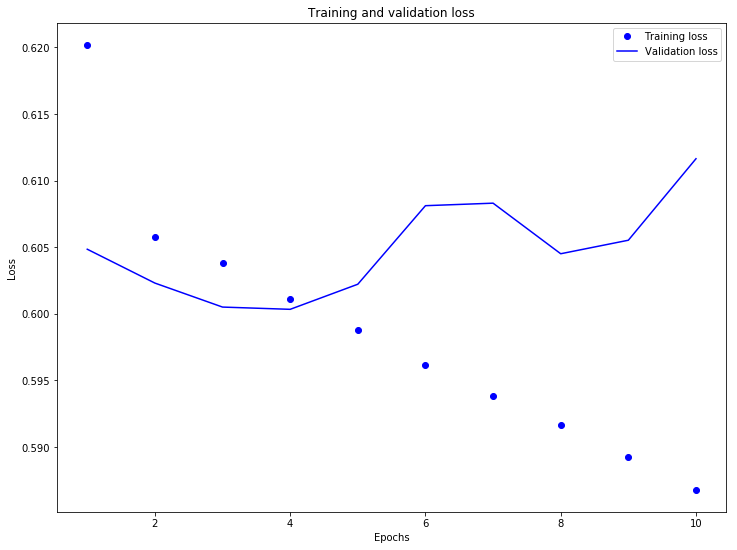

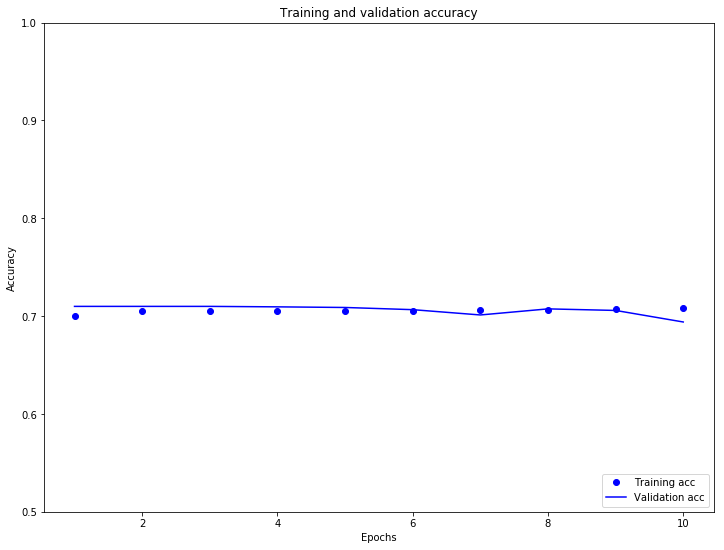

In [58]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [59]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(4000, 100)


In [91]:
import io


out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(tokenizer.word_index):  
    if num < 4000:
        vec = weights[num-1]
        out_m.write(word + "\n")
        out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [96]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()
    
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(4000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
    ])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          256000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 195       
Total params: 330,499
Trainable params: 330,499
Non-trainable params: 0
_________________________________________________________________


In [97]:

history = model.fit(
    sequences, y_train,
    validation_split = .1,
    epochs=10
    )

Train on 56432 samples, validate on 6271 samples
Epoch 1/10
  192/56432 [..............................] - ETA: 2:10:00 - loss: 1.0405 - accuracy: 0.6687

KeyboardInterrupt: 

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [98]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(4000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())
history = model.fit(
    sequences, y_train,
    validation_split = .1,
    epochs=10
    )

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fcec002aef0>>
Train on 56432 samples, validate on 6271 samples
Epoch 1/10
   64/56432 [..............................] - ETA: 5:12:22 - loss: 1.0980 - accuracy: 0.4688

KeyboardInterrupt: 